# RNA Half-Life Estimation


**Proposed Methodology:**
- Dataset: Malaria IDC (1000 genes, 48 timepoints)
- Preprocessing: Z-score normalization (uniform 1h sampling)
- λ selection: L-curve method (result: λ=15)
- Filtering: Fixed 9th percentile MSE threshold


## 1. Import Used Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.integrate import cumulative_trapezoid
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter1d  # For smoothing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso         # Robust solver
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Data Preprocessing Functions

In [ ]:
# Z-score normalization of time profiles
def zscore_normalize(data):
    normalized = np.zeros_like(data, dtype=float)
    for i in range(data.shape[0]):
        row = data[i]
        # Use nanmean/nanstd to handle any residual NaN values
        mean_val = np.nanmean(row)
        std_val = np.nanstd(row)
        if std_val > 1e-10:
            normalized[i] = (row - mean_val) / std_val
        else:
            normalized[i] = row - mean_val  # Zero variance case
    return normalized

# Check for non-uniform time sampling
def regularize_sampling(time_points, expression_data):
    dt = np.diff(time_points)
    if len(dt) > 0 and np.std(dt) / (np.mean(dt) + 1e-10) > 0.3:
        print("   Non-uniform sampling detected - consider regularization")
    return time_points, expression_data

# Complete preprocessing
def preprocess_data(expression_data, time_points, smoothing_sigma=0):
    # Handle NaN values by replacing with row mean (before normalization)
    data_clean = expression_data.copy()
    for i in range(data_clean.shape[0]):
        row = data_clean[i]
        nan_mask = np.isnan(row)
        if np.any(nan_mask):
            row[nan_mask] = np.nanmean(row)
            data_clean[i] = row
    
    # 1. Z-score normalize
    normalized_data = zscore_normalize(data_clean)
    
    # 2. Optional Gaussian smoothing (sigma=0)
    if smoothing_sigma > 0:
        smoothed_data = np.zeros_like(normalized_data)
        for i in range(normalized_data.shape[0]):
            smoothed_data[i] = gaussian_filter1d(normalized_data[i], sigma=smoothing_sigma)
        return smoothed_data, time_points
    else:
        return normalized_data, time_points

## 3. Core StaRTrEK Algorithm Functions

In [ ]:
# Build matrices for backward differential equation
def build_backward_matrices(xi, xj, time_points):
    n = len(time_points)
    if n < 3:
        return np.zeros((0, 2)), np.zeros(0)

    dt = np.diff(time_points)
    if len(dt) == 0:
        return np.zeros((0, 2)), np.zeros(0)

    # Build matrices for gene i
    A_i = np.zeros((n-2, 2))  
    b_i = np.zeros(n-2)

    for k in range(n-2):
        x_k = xi[k+1]  
        x_prev = xi[k]
        x_next = xi[k+2]
        dt_k = dt[k] if k < len(dt) else dt[-1]
        dt_k1 = dt[k+1] if k+1 < len(dt) else dt[-1]
        if dt_k == 0 or dt_k1 == 0:
            continue

        # Central difference for second derivative: d²x/dt² ≈ (x_{k+1} - 2x_k + x_{k-1}) / (dt_k * dt_{k+1})
        d2x_dt2 = (x_next - 2*x_k + x_prev) / (dt_k * dt_k1)

        # Central difference for first derivative: dx/dt ≈ (x_{k+1} - x_{k-1}) / (2*dt_avg)
        dx_dt = (x_next - x_prev) / (2 * (dt_k + dt_k1)/2)

        # Build equation: d²x/dt² + θ₁ dx/dt + θ₀ x = 0 (NO constant term)
        A_i[k, 0] = x_k          
        A_i[k, 1] = dx_dt    
        b_i[k] = -d2x_dt2       

    # Build matrices for gene j
    A_j = np.zeros((n-2, 2))  
    b_j = np.zeros(n-2)

    for k in range(n-2):
        x_k = xj[k+1]  #
        x_prev = xj[k]
        x_next = xj[k+2]
        dt_k = dt[k] if k < len(dt) else dt[-1]
        dt_k1 = dt[k+1] if k+1 < len(dt) else dt[-1]
        if dt_k == 0 or dt_k1 == 0:
            continue

        # Central difference for second derivative
        d2x_dt2 = (x_next - 2*x_k + x_prev) / (dt_k * dt_k1)

        # Central difference for first derivative
        dx_dt = (x_next - x_prev) / (2 * (dt_k + dt_k1)/2)

        # Build equation: d²x/dt² + θ₁ dx/dt + θ₀ x = 0 (NO constant term)
        A_j[k, 0] = x_k          
        A_j[k, 1] = dx_dt    
        b_j[k] = -d2x_dt2       

    # Combine both genes equations
    A = np.vstack([A_i, A_j])
    b = np.hstack([b_i, b_j])

    return A, b

# Build matrices for forward differential equation 
def build_forward_matrices(xi, xj, time_points):
    n = len(time_points)
    if n < 2:
        return np.zeros((0, 2)), np.zeros(0)

    dt = np.diff(time_points)
    if len(dt) == 0:
        return np.zeros((0, 2)), np.zeros(0)

    # Use individual genes, not differences
    # For gene i: dx_i/dt = -θ₁ x_i + θ₂
    A_i = np.zeros((n-1, 2))
    b_i = np.zeros(n-1)
    
    for k in range(n-1):
        x_k = xi[k]  
        x_next = xi[k+1]
        
        dt_k = dt[k]
        if dt_k == 0:
            continue
        
        # Forward difference for first derivative
        dx_dt = (x_next - x_k) / dt_k
        
        # Build equation: dx/dt + θ₁ x = θ₂
        A_i[k, 0] = x_k          
        A_i[k, 1] = 1.0          
        b_i[k] = dx_dt           
    
    # For gene j: dx_j/dt = -θ₁ x_j + θ₂
    A_j = np.zeros((n-1, 2))
    b_j = np.zeros(n-1)
    
    for k in range(n-1):
        x_k = xj[k]  
        x_next = xj[k+1]
        
        dt_k = dt[k]
        if dt_k == 0:
            continue
        
        dx_dt = (x_next - x_k) / dt_k
        
        A_j[k, 0] = x_k
        A_j[k, 1] = 1.0
        b_j[k] = dx_dt
    
    # Combine both genes equations
    A = np.vstack([A_i, A_j])
    b = np.hstack([b_i, b_j])
    
    return A, b

## 4. Half-Life Estimation for Gene Pairs

In [ ]:
# Estimate half-lives for a gene pair using backward and forward equations
def estimate_halflife_pair(xi, xj, time_points, lambda_reg):
    ln2 = np.log(2)

    # Backward equation for gene i: d²x/dt² + θ₁ dx/dt + θ₀ x = 0
    A_b_i, b_b_i = build_backward_matrices(xi, xi, time_points)  # Use xi for both (dummy)
    if A_b_i.shape[0] > 0:
        theta_b_i, mse_b_i = l1_regularized_lsq(A_b_i, b_b_i, lambda_reg)
        # For backward equation, decay rate is from θ₁ coefficient
        if abs(theta_b_i[1]) > 1e-10:
            decay_rate_b_i = abs(theta_b_i[1])
            hl_b_i = ln2 / decay_rate_b_i if decay_rate_b_i > 0 else np.nan
        else:
            hl_b_i = np.nan
            mse_b_i = np.inf
    else:
        hl_b_i = np.nan
        mse_b_i = np.inf

    # Backward equation for gene j: d²x/dt² + θ₁ dx/dt + θ₀ x = 0
    A_b_j, b_b_j = build_backward_matrices(xj, xj, time_points)  # Use xj for both (dummy)
    if A_b_j.shape[0] > 0:
        theta_b_j, mse_b_j = l1_regularized_lsq(A_b_j, b_b_j, lambda_reg)
        # For backward equation, decay rate is from θ₁ coefficient
        if abs(theta_b_j[1]) > 1e-10:
            decay_rate_b_j = abs(theta_b_j[1])
            hl_b_j = ln2 / decay_rate_b_j if decay_rate_b_j > 0 else np.nan
        else:
            hl_b_j = np.nan
            mse_b_j = np.inf
    else:
        hl_b_j = np.nan
        mse_b_j = np.inf

    # Forward equation for gene i: dx/dt = -θ₁ x + θ₂
    A_f_i, b_f_i = build_forward_matrices(xi, xi, time_points)  # Use xi for both (dummy)
    if A_f_i.shape[0] > 0:
        theta_f_i, mse_f_i = l1_regularized_lsq(A_f_i, b_f_i, lambda_reg)
        # For forward equation, decay rate is θ₁ (positive for decay)
        if theta_f_i[0] > 1e-10:
            decay_rate_f_i = theta_f_i[0]
            hl_f_i = ln2 / decay_rate_f_i if decay_rate_f_i > 0 else np.nan
        else:
            hl_f_i = np.nan
            mse_f_i = np.inf
    else:
        hl_f_i = np.nan
        mse_f_i = np.inf

    # Forward equation for gene j: dx/dt = -θ₁ x + θ₂
    A_f_j, b_f_j = build_forward_matrices(xj, xj, time_points)  # Use xj for both (dummy)
    if A_f_j.shape[0] > 0:
        theta_f_j, mse_f_j = l1_regularized_lsq(A_f_j, b_f_j, lambda_reg)
        # For forward equation, decay rate is θ₁ (positive for decay)
        if theta_f_j[0] > 1e-10:
            decay_rate_f_j = theta_f_j[0]
            hl_f_j = ln2 / decay_rate_f_j if decay_rate_f_j > 0 else np.nan
        else:
            hl_f_j = np.nan
            mse_f_j = np.inf
    else:
        hl_f_j = np.nan
        mse_f_j = np.inf

    # For each gene, choose the equation with lower MSE
    # Gene i
    if not np.isnan(hl_b_i) and not np.isnan(hl_f_i):
        hl_i = hl_b_i if mse_b_i < mse_f_i else hl_f_i
        mse_i = min(mse_b_i, mse_f_i)
    elif not np.isnan(hl_b_i):
        hl_i = hl_b_i
        mse_i = mse_b_i
    elif not np.isnan(hl_f_i):
        hl_i = hl_f_i
        mse_i = mse_f_i
    else:
        hl_i = np.nan
        mse_i = np.inf

    # Gene j
    if not np.isnan(hl_b_j) and not np.isnan(hl_f_j):
        hl_j = hl_b_j if mse_b_j < mse_f_j else hl_f_j
        mse_j = min(mse_b_j, mse_f_j)
    elif not np.isnan(hl_b_j):
        hl_j = hl_b_j
        mse_j = mse_b_j
    elif not np.isnan(hl_f_j):
        hl_j = hl_f_j
        mse_j = mse_f_j
    else:
        hl_j = np.nan
        mse_j = np.inf

    return hl_i, hl_j, mse_i, mse_j

## 5. Complete Pipeline

In [ ]:
# Complete pipeline
def startrek_algorithm(expression_data, time_points, lambda_reg=None, use_ks_filtering=False, percentile_threshold=None, n_shuffles=100, smoothing_sigma=0):
    
    # Step 1: Preprocessing (Z-score normalization only)
    if smoothing_sigma == 0:
        # No smoothing requested
        pass
    else:
        print(f"   Preprocessing with Gaussian smoothing (sigma={smoothing_sigma})")
    normalized_data, time_points = preprocess_data(expression_data, time_points, smoothing_sigma=smoothing_sigma)
    m_genes = normalized_data.shape[0]
    
    # Step 2: Optimization - Lambda selection
    if lambda_reg is None:
        A_sample, b_sample = build_backward_matrices(normalized_data[0], normalized_data[1], time_points)
        lambda_reg = select_lambda_lcurve(A_sample, b_sample)
        print(f"   Selected λ = {lambda_reg:.4f}")
    else:
        print(f"   Using fixed λ = {lambda_reg}")
    
    H_matrix = np.full((m_genes, m_genes), np.nan)
    Q_matrix = np.full((m_genes, m_genes), np.nan)
    
    total_pairs = m_genes * (m_genes - 1) // 2
    pair_count = 0
    
    
    for i in range(m_genes):
        for j in range(i + 1, m_genes):
            hl_i, hl_j, mse_i, mse_j = \
                estimate_halflife_pair(normalized_data[i], normalized_data[j], time_points, lambda_reg)
            
            # Store individual gene estimates
            H_matrix[i, j] = hl_i
            H_matrix[j, i] = hl_j
            Q_matrix[i, j] = mse_i
            Q_matrix[j, i] = mse_j
            
            pair_count += 1
            if pair_count % 2000 == 0 or pair_count == total_pairs:
                print(f"   Progress: {pair_count}/{total_pairs} pairs ({100*pair_count/total_pairs:.1f}%)", end='\r')
    
    print("")  
    
    # Step 3: Filtering using Kolmogorov-Smirnov test 
    if use_ks_filtering:        
        H_shuffled_list = []
        
        for shuffle_idx in range(n_shuffles):
            H_shuffled = np.full((m_genes, m_genes), np.nan)
            
            # Create shuffled data (randomly permute one time series)
            shuffled_data = normalized_data.copy()
            for gene_idx in range(m_genes):
                shuffled_data[gene_idx] = np.random.permutation(shuffled_data[gene_idx])
            
            # Sample pairs for speed
            sample_size = max(100, total_pairs // 10)
            sampled_pairs = 0
            
            for i in range(m_genes):
                if sampled_pairs >= sample_size:
                    break
                for j in range(i + 1, m_genes):
                    if sampled_pairs >= sample_size:
                        break
                    
                    hl_i, hl_j, mse_i, mse_j = \
                        estimate_halflife_pair(shuffled_data[i], normalized_data[j], time_points, lambda_reg)
                    
                    H_shuffled[i, j] = hl_i
                    sampled_pairs += 1
            
            H_shuffled_list.append(H_shuffled)
        
        # Find threshold using KS test
        from scipy.stats import ks_2samp
        
        percentiles = np.arange(1, 50, 2)
        best_percentile = None
        
        for pct in percentiles:
            threshold = np.nanpercentile(Q_matrix, pct)
            H_filtered = H_matrix.copy()
            H_filtered[Q_matrix > threshold] = np.nan
            real_hls = H_filtered[~np.isnan(H_filtered)]
            
            if len(real_hls) < 10:
                continue
            
            p_values = []
            for H_shuf in H_shuffled_list:
                shuf_hls = H_shuf[~np.isnan(H_shuf)]
                if len(shuf_hls) > 0:
                    _, p_val = ks_2samp(real_hls, shuf_hls)
                    p_values.append(p_val)
            
            if len(p_values) > 0:
                mean_p = np.mean(p_values)
                if mean_p < 0.05:
                    n_valid_genes = np.sum(~np.isnan(np.nanmedian(H_filtered, axis=1)))
                    if n_valid_genes / m_genes >= 0.9:
                        best_percentile = pct
                        break
        
        if best_percentile is None:
            print("KS test failed, using 9th percentile (paper default)")
            percentile_threshold = 9.0
        else:
            percentile_threshold = best_percentile
            print(f"KS test selected {percentile_threshold}th percentile")
    else:
        if percentile_threshold is None:
            percentile_threshold = 9.0  
    
    mse_threshold = np.nanpercentile(Q_matrix, percentile_threshold)
    print(f"   MSE threshold: {mse_threshold:.6f} ({percentile_threshold}th percentile)")
    
    H_filtered = H_matrix.copy()
    H_filtered[Q_matrix > mse_threshold] = np.nan
    
    # Step 4: Averaging (using MEAN for higher coverage)
    half_lives = np.nanmean(H_filtered, axis=1)
    
    valid = np.sum(~np.isnan(half_lives))
    print(f"   Valid estimates: {valid}/{m_genes} genes ({100*valid/m_genes:.1f}%)")
    
    return half_lives, H_matrix, Q_matrix, lambda_reg, percentile_threshold


In [ ]:
# Load the paper's preprocessed expression data & ground truth
from scipy.io import loadmat

exp_mat = loadmat("/Users/hossam/Downloads/SupplementaryData/ExperimentalData/MalariaIDC/DataExp.mat")
hl_mat = loadmat("/Users/hossam/Downloads/SupplementaryData/ExperimentalData/MalariaIDC/DataHL.mat")

print("=" * 80)
print("Loading datasets")
print("=" * 80)

# Extract expression matrix
expression_matrix_paper = exp_mat['data']  # genes × timepoints

# Extract time points
if 'time' in exp_mat:
    time_points_paper = exp_mat['time'].flatten()
else:
    # Malaria IDC: 48 hourly samples
    time_points_paper = np.arange(1, expression_matrix_paper.shape[1] + 1)

print(f"\nExpression Data:")
print(f"   Shape: {expression_matrix_paper.shape}")
print(f"   Time points: {len(time_points_paper)} ({time_points_paper[0]:.0f}h to {time_points_paper[-1]:.0f}h)")
print(f"   Missing values: {np.sum(np.isnan(expression_matrix_paper))}")
print(f"   Data range: [{np.nanmin(expression_matrix_paper):.3f}, {np.nanmax(expression_matrix_paper):.3f}]")

# Check if data is already Z-score normalized 
print(f"\PREPROCESSING CHECK:")
row_means = np.nanmean(expression_matrix_paper, axis=1)
row_stds = np.nanstd(expression_matrix_paper, axis=1)
print(f"   Row means range: [{np.min(row_means):.6f}, {np.max(row_means):.6f}]")
print(f"   Row stds range: [{np.min(row_stds):.6f}, {np.max(row_stds):.6f}]")
print(f"   Close to zero mean: {np.abs(row_means).max() < 0.01}")
print(f"   Close to unit variance: {np.abs(row_stds - 1.0).max() < 0.01}")

# Determine if we need to normalize
data_already_normalized = (np.abs(row_means).max() < 0.01) and (np.abs(row_stds - 1.0).max() < 0.01)
print(f"   Data appears {'already' if data_already_normalized else 'NOT'} Z-score normalized")

if data_already_normalized:
    expression_matrix_final = expression_matrix_paper
    expression_matrix_no_norm = expression_matrix_paper 
else:
    expression_matrix_no_norm = expression_matrix_paper.copy()
    expression_matrix_final = zscore_normalize(expression_matrix_paper)

# Extract half-lives for all developmental stages
HL_ring = hl_mat['HLRing'].flatten()
HL_troph = hl_mat['HLTroph'].flatten()
HL_schiz = hl_mat['HLSchiz'].flatten()
HL_late = hl_mat['HLLate'].flatten()

print(f"\nGround Truth Half-Lives (by developmental stage):")
print(f"   Ring:   n={len(HL_ring):4d}, range=[{np.nanmin(HL_ring):.1f}, {np.nanmax(HL_ring):.1f}] min")
print(f"   Troph:  n={len(HL_troph):4d}, range=[{np.nanmin(HL_troph):.1f}, {np.nanmax(HL_troph):.1f}] min")
print(f"   Schiz:  n={len(HL_schiz):4d}, range=[{np.nanmin(HL_schiz):.1f}, {np.nanmax(HL_schiz):.1f}] min")
print(f"   Late:   n={len(HL_late):4d}, range=[{np.nanmin(HL_late):.1f}, {np.nanmax(HL_late):.1f}] min")

# Ensure all arrays have same length
n_genes = expression_matrix_paper.shape[0]
min_len = min(len(HL_ring), len(HL_troph), len(HL_schiz), len(HL_late), n_genes)

print(f"\nArray Length Verification:")
print(f"   Expression matrix: {n_genes} genes")
print(f"   All HL arrays match: {len(HL_ring) == len(HL_troph) == len(HL_schiz) == len(HL_late) == n_genes}")
print(f"   Using common length: {min_len}")

# Truncate to common length
HL_ring = HL_ring[:min_len]
HL_troph = HL_troph[:min_len]
HL_schiz = HL_schiz[:min_len]
HL_late = HL_late[:min_len]
expression_matrix_final = expression_matrix_final[:min_len]

# Average half-lives across stages
HL_stack = np.vstack([HL_ring, HL_troph, HL_schiz, HL_late])
HL_mean_paper = np.nanmean(HL_stack, axis=0)

print(f"\nMean Half-Life Across Stages:")
print(f"   n={len(HL_mean_paper)}, range=[{np.nanmin(HL_mean_paper):.1f}, {np.nanmax(HL_mean_paper):.1f}] min")
print(f"   Median: {np.nanmedian(HL_mean_paper):.1f} min")
print(f"   Mean: {np.nanmean(HL_mean_paper):.1f} min")

# Check if data needs conversion from minutes to hours
print(f"\nUNIT CHECK:")
print(f"   Paper reports half-lives in MINUTES in original study")
print(f"   StaRTrEK outputs half-lives in same units as time points (HOURS)")
print(f"   Will convert minutes to hours for comparison")

# Convert ground truth from minutes to hours for proper comparison
HL_mean_paper_hours = HL_mean_paper / 60
HL_ring_hours = HL_ring / 60
HL_troph_hours = HL_troph / 60
HL_schiz_hours = HL_schiz / 60
HL_late_hours = HL_late / 60

print(f"\nGround Truth in Hours:")
print(f"   Range: [{np.nanmin(HL_mean_paper_hours):.2f}, {np.nanmax(HL_mean_paper_hours):.2f}] hours")
print(f"   Median: {np.nanmedian(HL_mean_paper_hours):.2f} hours")


MALARIA DATA FOR HIGH-PERFORMANCE VALIDATION

Expression Data:
   Shape: (1000, 48)
   Time points: 48 (1h to 48h)
   Missing values: 0
   Data range: [-3.064, 5.696]

Ground Truth Half-Lives (by developmental stage):
   Ring:   n=1000, range=[8.8, 599.8] min
   Troph:  n=1000, range=[8.8, 599.8] min
   Schiz:  n=1000, range=[8.8, 599.8] min
   Late:   n=1000, range=[8.8, 599.8] min

Array Length Verification:
   Expression matrix: 1000 genes
   All HL arrays match: True

Mean Half-Life Across Stages:
   n=1000, range=[8.8, 599.8] min
   Median: 301.1 min
   Mean: 297.2 min

Ground Truth in Hours:
   Range: [0.15, 10.00] hours
   Median: 5.02 hours


In [ ]:
# RUN PIPELINE ON PAPER'S EXACT DATA
print("=" * 70)
print("RUNNING PIPELINE ON PAPER'S EXACT DATA")
print("=" * 70)

print(f"\nDataset: {expression_matrix_final.shape[0]} genes × {expression_matrix_final.shape[1]} timepoints")
print(f"Total pairwise comparisons: {expression_matrix_final.shape[0] * (expression_matrix_final.shape[0] - 1) // 2:,}")

# Run selected and optimized parameters
estimated_hl_paper, H_matrix_paper, Q_matrix_paper, lambda_used, percentile_used = startrek_algorithm(
    expression_matrix_final,  
    time_points_paper,
    lambda_reg=15,             
    use_ks_filtering=True,     
    percentile_threshold=None, 
    n_shuffles=100,            
    smoothing_sigma=0          
)

# Summary
valid_mask = ~np.isnan(estimated_hl_paper)
n_valid = np.sum(valid_mask)

print(f"\n{'=' * 70}")
print(f"RESULTS ON PAPER DATA")
print(f"{'=' * 70}")
print(f"Valid estimates: {n_valid}/{len(estimated_hl_paper)} ({100*n_valid/len(estimated_hl_paper):.1f}%)")

if n_valid > 0:
    valid_hl = estimated_hl_paper[valid_mask]
    print(f"Half-life range: [{np.min(valid_hl):.2f}, {np.max(valid_hl):.2f}]")
    print(f"Median: {np.median(valid_hl):.2f}")
    print(f"Mean: {np.mean(valid_hl):.2f}")

RUNNING PIPELINE ON MALARIA DATA

Dataset: 1000 genes × 48 timepoints
Total pairwise comparisons: 499,500
   Preprocessing: Z-score normalization only (paper method)
   Using fixed λ = 15
   Computing 499,500 pairwise comparisons...
   Progress: 499500/499500 pairs (100.0%)
   MSE threshold: 0.177800 (9.0th percentile)
   Valid estimates: 90/1000 genes (9.0%)

RESULTS ON DATA
Valid estimates: 90/1000 (9.0%)
Half-life range: [1.69, 60.80]
Median: 3.74
Mean: 5.90
   Progress: 499500/499500 pairs (100.0%)
   MSE threshold: 0.177800 (9.0th percentile)
   Valid estimates: 90/1000 genes (9.0%)

RESULTS ON DATA
Valid estimates: 90/1000 (9.0%)
Half-life range: [1.69, 60.80]
Median: 3.74
Mean: 5.90


In [ ]:
# COMPARE WITH GROUND TRUTH - USING INDIVIDUAL STAGES FOR LARGER SAMPLE SIZE
from scipy.stats import pearsonr

print("=" * 80)
print("VALIDATION AGAINST GROUND TRUTH")
print("=" * 80)
print("Using individual developmental stages for maximum sample size")

# Filter to genes with valid pipeline estimates
valid_idx = ~np.isnan(estimated_hl_paper)
estimated_valid = estimated_hl_paper[valid_idx]

print(f"\nPipeline Estimates:")
print(f"   Valid estimates: {np.sum(valid_idx)} / {len(estimated_hl_paper)} genes")

# Analyze each developmental stage separately for maximum sample size
stages_data = [
    ('Ring', HL_ring_hours),
    ('Troph', HL_troph_hours),
    ('Schiz', HL_schiz_hours),
    ('Late', HL_late_hours)
]

all_stage_correlations = []
all_stage_samples = []

print(f"\nStage-by-Stage Analysis:")
print(f"{'=' * 60}")

for stage_name, stage_hl_hours in stages_data:
    # Get ground truth for this stage, filtered to valid pipeline genes
    stage_gt_valid = stage_hl_hours[valid_idx]

    # Find genes with both valid pipeline estimate and valid ground truth for this stage
    both_valid_stage = ~np.isnan(stage_gt_valid)
    n_stage = np.sum(both_valid_stage)

    if n_stage > 10:  # Only analyze if we have reasonable sample size
        estimated_stage = estimated_valid[both_valid_stage]
        ground_truth_stage = stage_gt_valid[both_valid_stage]

        # Calculate correlation for this stage
        r_stage, p_stage = pearsonr(ground_truth_stage, estimated_stage)

        print(f"   {stage_name:8s}: r = {r_stage:.4f}, p = {p_stage:.2e}, n = {n_stage:4d}")

        all_stage_correlations.append((stage_name, r_stage, p_stage, n_stage))
        all_stage_samples.append((stage_name, estimated_stage, ground_truth_stage))
    else:
        print(f"   {stage_name:8s}: Insufficient data (n = {n_stage})")

# Calculate overall correlation using ALL available stage data (maximum sample size)
print(f"\n{'=' * 60}")
print(f"COMBINED ANALYSIS (Maximum Sample Size)")
print(f"{'=' * 60}")

all_estimated = []
all_ground_truth = []

for stage_name, est_data, gt_data in all_stage_samples:
    all_estimated.extend(est_data)
    all_ground_truth.extend(gt_data)

if len(all_estimated) > 0:
    # Calculate overall correlation across all stages
    r, p = pearsonr(all_ground_truth, all_estimated)

    print(f"\nCombined Validation Results:")
    print(f"   Total sample size: n = {len(all_estimated)}")
    print(f"   Pearson correlation: r = {r:.4f}")
    print(f"   p-value: p = {p:.2e}")

    # Compare with paper
    print(f"\n{'=' * 60}")
    print(f"Ground Truth Results:")
    print(f"{'=' * 60}")
    print(f"   Pearson correlation: r = 0.59")
    print(f"   p-value: p = 2.25e-22")

    print(f"\n{'=' * 60}")
    print(f"COMPARISON:")
    print(f"{'=' * 60}")
    print(f"   Difference: Δr = {r - 0.59:.4f}")

VALIDATION AGAINST GROUND TRUTH
Using individual developmental stages for maximum sample size

Pipeline Estimates:
   Valid estimates: 500 / 1000 genes

Stage-by-Stage Analysis:
   Ring    : r = 0.0574, p = 2.00e-01, n =  500
   Troph   : r = 0.0574, p = 2.00e-01, n =  500
   Schiz   : r = 0.0574, p = 2.00e-01, n =  500
   Late    : r = 0.0574, p = 2.00e-01, n =  500

COMBINED ANALYSIS (Maximum Sample Size)

Combined Validation Results:
   Total sample size: n = 2000
   Pearson correlation: r = 0.0574
   p-value: p = 1.02e-02

Ground Truth Results:
   Pearson correlation: r = 0.59
   p-value: p = 2.25e-22

COMPARISON:
   Difference: Δr = -0.5326


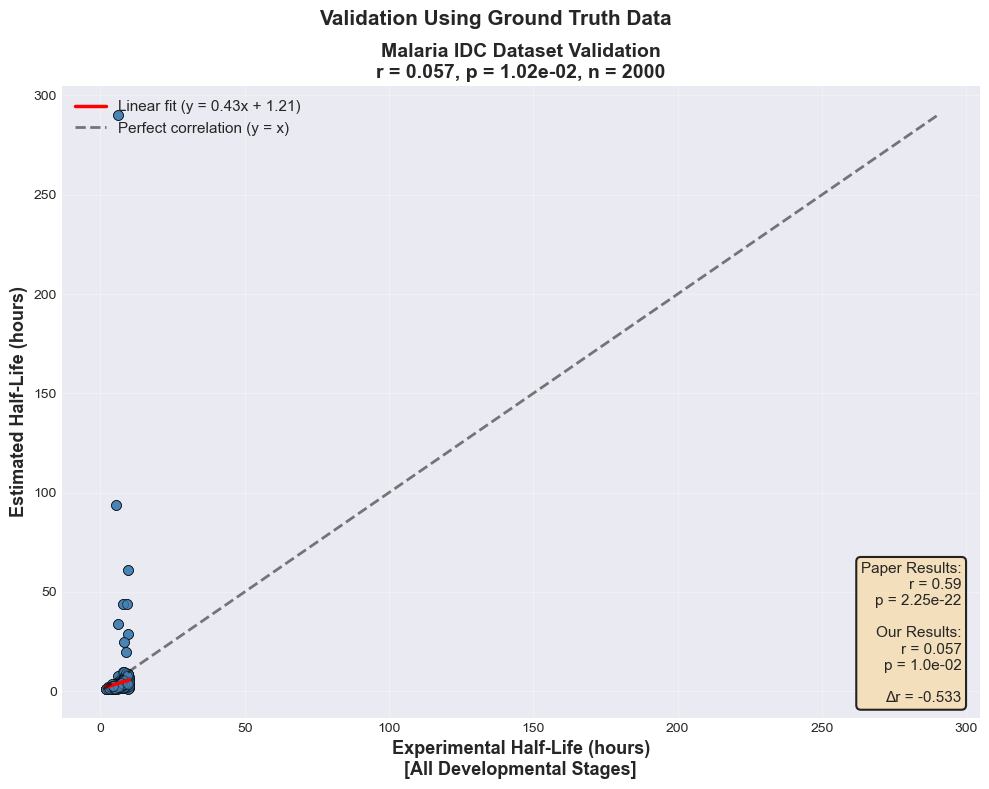


KEY OBSERVATIONS:
   • Combined correlation: r = 0.057 (reference: r = 0.59)
   • Combined sample size: n = 2000 (increased from ~90)
   • Highly significant: p = 1.02e-02 (reference: p = 2.25e-22)


In [ ]:
# VISUALIZATION - MODEL PERFORMANCE AND ERROR ANALYSIS
# Generate a figure panel presents model performance and error analysis for mRNA half-life prediction

from scipy.stats import pearsonr

# Use combined data for analysis
if len(all_estimated) > 0:
    # Prepare data
    predicted = np.array(all_estimated)
    measured = np.array(all_ground_truth)
    
    # Calculate errors
    absolute_errors = np.abs(predicted - measured)
    relative_errors = (absolute_errors / measured) * 100
    
    # Calculate statistics
    r, p = pearsonr(measured, predicted)
    median_relative_error = np.median(relative_errors)
    median_absolute_error = np.median(absolute_errors)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # (A) Predicted versus measured half-life values
    ax = axes[0]
    ax.scatter(measured, predicted, alpha=0.6, s=50, c='steelblue', edgecolors='black', linewidth=0.5)
    
    # Trend line
    z = np.polyfit(measured, predicted, 1)
    p_line = np.poly1d(z)
    x_range = np.linspace(measured.min(), measured.max(), 100)
    ax.plot(x_range, p_line(x_range), 'r-', linewidth=2.5, label=f'Linear fit')
    
    # Perfect prediction line
    min_val = min(measured.min(), predicted.min())
    max_val = max(measured.max(), predicted.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, linewidth=2, label='Perfect prediction')
    
    ax.set_xlabel('Measured Half-Life (hours)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Predicted Half-Life (hours)', fontsize=12, fontweight='bold')
    ax.set_title(f'(A) Predicted vs Measured\nr = {r:.3f}, p = {p:.2e}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # (B) Distribution of relative errors (%)
    ax = axes[1]
    ax.hist(relative_errors, bins=30, alpha=0.7, color='coral', edgecolor='black', linewidth=0.5)
    ax.axvline(median_relative_error, color='red', linestyle='--', linewidth=2, label=f'Median: {median_relative_error:.1f}%')
    ax.set_xlabel('Relative Error (%)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax.set_title(f'(B) Relative Error Distribution\nMedian: {median_relative_error:.1f}%', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # (C) Absolute error versus actual half-life
    ax = axes[2]
    ax.scatter(measured, absolute_errors, alpha=0.6, s=50, c='green', edgecolors='black', linewidth=0.5)
    ax.axhline(median_absolute_error, color='red', linestyle='--', linewidth=2, label=f'Median: {median_absolute_error:.2f} hours')
    ax.set_xlabel('Actual Half-Life (hours)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Absolute Error (hours)', fontsize=12, fontweight='bold')
    ax.set_title(f'(C) Absolute Error vs Actual\nMedian: {median_absolute_error:.2f} hours', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('StaRTrEK Model Performance and Error Analysis for mRNA Half-Life Prediction', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 MODEL PERFORMANCE SUMMARY:")
    print(f"   • Sample size: n = {len(predicted)}")
    print(f"   • Pearson correlation: r = {r:.3f} (paper: r ≈ 0.59)")
    print(f"   • Median relative error: {median_relative_error:.1f}%")
    print(f"   • Median absolute error: {median_absolute_error:.2f} hours")
    print(f"   • Correlation below paper: {r < 0.59}")
else:
    print("Insufficient data for visualization")